In [140]:
import pandas as pd
import fiona
import seaborn
# import geopandas as gp
# from geopandas import GeoDataFrame
# from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pylab as pl
from pylab import rcParams
import matplotlib.pyplot as plt

import csv

from datetime import datetime
from dateutil.parser import parse

%matplotlib inline

# 1. Importing 311 data and selecting relevant subset

## Importing separate CSVs for DOHMH and HPD data.

This set filtered for complaints under Department of Health and Mental Hygiene from January 1, 2016 through December 31, 2016.

In [2]:
health = pd.read_csv('Data/311_Service_Requests_DOHMH_2016.csv')
len(health)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


66591

This set filtered for complaints under Department of Housing Preservation and Development from January 1, 2016 through December 31, 2016.

In [3]:
housing = pd.read_csv('Data/311_Service_Requests_HPD_2016.csv')
len(housing)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (20,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


596190

In [4]:
housing['Location Type'].unique()

array(['RESIDENTIAL BUILDING', nan], dtype=object)

In [5]:
housing = housing[housing['Location Type'] == 'RESIDENTIAL BUILDING']
len(housing)

592652

After removing NaN values in the Location Type field, the number of HPD complaints is reduced from 596,190 to 592,652.

## Selecting only DOHMH complaints about landlord issues in residential buildings

In [6]:
health['Location Type'].unique()

array(['Residential Building', 'Restaurant/Bar/Deli/Bakery', 'Vacant Lot',
       'Other (Explain Below)', '3+ Family Apt. Building',
       '1-2 Family Dwelling', 'Commercial Building',
       '1-2 Family Mixed Use Building', 'Apartment', 'Vacant Building',
       '3+ Family Apartment Building', 'Catch Basin/Sewer',
       '3+ Family Mixed Use Building', 'Public Garden', 'Food Cart Vendor',
       'Building (Non-Residential)', 'Pet Shop', 'Construction Site',
       'Residence', 'Parking Lot/Garage', 'Steam Room',
       'Single Room Occupancy (SRO)', 'Public/Unfenced Area',
       'Cafeteria - Private', 'Senior Center', 'Pool', 'Public Stairs',
       'Spa Pool', 'Other', 'Restaurant', '1-3 Family Dwelling', 'Groomer',
       'Tattoo Parlor', 'School/Pre-School', 'Office Building',
       'Government Building', 'Hospital', 'School', 'Private School',
       'Private House', 'Day Care/Nursery', 'Cafeteria - Private School',
       'Soup Kitchen', 'Public School', 'Nursing Home',
     

In [7]:
residential = ('Residential Building', '3+ Family Apt. Building', '1-2 Family Dwelling', 
                                     '1-2 Family Mixed Use Building', 'Apartment',  '3+ Family Apartment Building',
                                     '3+ Family Mixed Use Building', 'Residence', 'Single Room Occupancy (SRO)',
                                     '1-3 Family Dwelling', 'Residential Property', '1-3 Family Mixed Use Building')
health = health.loc[health['Location Type'].isin(residential)]
len(health)

35943

After selecting for only residential buildings, the number of DOHMH complaints is reduced from 66,591 to 35,943.

In [8]:
health['Complaint Type'].unique()

array(['Smoking', 'Rodent', 'Unsanitary Animal Pvt Property', 'Day Care',
       'Indoor Air Quality', 'Indoor Sewage',
       'Unsanitary Pigeon Condition', 'Illegal Animal Kept as Pet',
       'Drinking Water', 'Asbestos', 'Window Guard', 'Illegal Animal Sold',
       'Food Establishment', 'Harboring Bees/Wasps', 'Poison Ivy',
       'Standing Water', 'Asbestos/Garbage Nuisance', 'Mosquitoes', 'LEAD',
       'Trapping Pigeon'], dtype=object)

In [9]:
landlord_issues10 = ('Smoking', 'Rodent',
       'Indoor Air Quality', 'Indoor Sewage',
       'Unsanitary Pigeon Condition',
       'Drinking Water', 'Window Guard',
       'Standing Water', 'Mosquitoes')
health = health.loc[health['Complaint Type'].isin(landlord_issues10)]
len(health)

34856

After selecting for only things that endanger tenants or affect their quality of life and that landlords can control, the number of DOHMH complaints is reduced from 35,943 to 32,356.

## Combining health and housing data sets.

In [110]:
frames = [health, housing]
data = pd.concat(frames)
print(len(data))
data.columns

627508


Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry 

In [111]:
data.drop(['Agency Name', 'Street Name', 'Address Type',
       'City', 'Landmark', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction',
       'Ferry Terminal Name', 'Intersection Street 1', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 2', 'Facility Type', 'Location', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [112]:
data['Complaint Type'].unique()

array(['Smoking', 'Rodent', 'Unsanitary Animal Pvt Property',
       'Indoor Air Quality', 'Indoor Sewage',
       'Unsanitary Pigeon Condition', 'Drinking Water', 'Window Guard',
       'Standing Water', 'Mosquitoes', 'UNSANITARY CONDITION',
       'DOOR/WINDOW', 'ELECTRIC', 'HEAT/HOT WATER', 'APPLIANCE', 'GENERAL',
       'PLUMBING', 'SAFETY', 'WATER LEAK', 'FLOORING/STAIRS',
       'OUTSIDE BUILDING', 'PAINT/PLASTER', 'ELEVATOR', 'AGENCY',
       'VACANT APARTMENT'], dtype=object)

In [113]:
landlord_issues3 = ('Smoking', 'Rodent',
       'Indoor Air Quality', 'Indoor Sewage',
       'Unsanitary Pigeon Condition',
       'Drinking Water', 'Window Guard',
       'Standing Water', 'Mosquitoes', 'UNSANITARY CONDITION',
       'DOOR/WINDOW', 'ELECTRIC', 'HEAT/HOT WATER', 'APPLIANCE', 'GENERAL',
       'PLUMBING', 'SAFETY', 'WATER LEAK', 'FLOORING/STAIRS',
       'OUTSIDE BUILDING', 'PAINT/PLASTER', 'ELEVATOR')
data = data.loc[data['Complaint Type'].isin(landlord_issues3)]
len(data)

625367

# 2. Counting the number of complaints of each type or descriptor

## Combining similar complaints

This creates a single field to include both Complaint Type and Descriptor. This will then be altered to put similar complaints into single categories.

In [114]:
data['New_Description'] = data['Complaint Type'] + " – " + data['Descriptor']
data.head()

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,New_Description
0,32306500,01/01/2016 12:32:21 AM,NaN,DOHMH,Smoking,Smoking Violation,Residential Building,10468.0,2337 GRAND CONCOURSE,Smoking – Smoking Violation
4,32310788,01/01/2016 12:00:00 AM,11/23/2015 12:00:00 AM,DOHMH,Rodent,Mouse Sighting,3+ Family Apt. Building,10029.0,2172 2ND AVENUE,Rodent – Mouse Sighting
5,32310789,01/01/2016 12:00:00 AM,NaN,DOHMH,Rodent,Mouse Sighting,3+ Family Apt. Building,11432.0,159-44 NORMAL ROAD,Rodent – Mouse Sighting
6,32310790,01/01/2016 12:00:00 AM,01/20/2016 12:00:00 AM,DOHMH,Rodent,Mouse Sighting,3+ Family Apt. Building,11210.0,2300 KINGS HIGHWAY,Rodent – Mouse Sighting
7,32310791,01/01/2016 12:00:00 AM,11/23/2015 12:00:00 AM,DOHMH,Rodent,Mouse Sighting,3+ Family Apt. Building,10029.0,2172 2ND AVENUE,Rodent – Mouse Sighting


In [138]:
data.to_csv("data.csv")

In [119]:
data.loc[data['Complaint Type'] == 'Rodent', 'New_Description'] = 'Pests'
data.loc[data['Complaint Type'] == 'HEAT/HOT WATER', 'New_Description'] = 'HEAT/HOT WATER'
data.loc[data['New_Description'] == 'UNSANITARY CONDITION – PESTS', 'New_Description'] = 'Pests'
data.loc[data['Complaint Type'] == 'PAINT/PLASTER', 'New_Description'] = 'PAINT/PLASTER'
data.loc[data['New_Description'] == 'UNSANITARY CONDITION – MOLD', 'New_Description'] = 'Mold'
data.loc[data['Complaint Type'] == 'PLUMBING', 'New_Description'] = 'Plumbing/Water Leak'
data.loc[data['Complaint Type'] == 'WATER LEAK', 'New_Description'] = 'Plumbing/Water Leak'
data.loc[data['New_Description'] == 'GENERAL – COOKING GAS', 'New_Description'] = 'Fire Risk'
data.loc[data['New_Description'] == 'APPLIANCE – ELECTRIC/GAS RANGE', 'New_Description'] = 'Fire Risk'
data.loc[data['Complaint Type'] == 'DOOR/WINDOW', 'New_Description'] = 'DOOR/WINDOW'
data.loc[data['Complaint Type'] == 'ELECTRIC', 'New_Description'] = 'ELECTRIC'
data.loc[data['New_Description'] == 'SAFETY – CARBON MONOXIDE DETECTOR', 'New_Description'] = 'Air Quality'
data.loc[data['New_Description'] == 'GENERAL – VENTILATION SYSTEM', 'New_Description'] = 'Air Quality'
data.loc[data['Complaint Type'] == 'FLOORING/STAIRS', 'New_Description'] = 'FLOORING/STAIRS'
data.loc[data['New_Description'] == 'Indoor Air Quality – Chemical Vapors/Gases/Odors', 'New_Description'] = 'Air Quality'
data.loc[data['New_Description'] == 'UNSANITARY CONDITION – SEWAGE', 'New_Description'] = 'Sewage'
data.loc[data['New_Description'] == 'Indoor Sewage – Sewage Odor', 'New_Description'] = 'Sewage'
data.loc[data['Complaint Type'] == 'Indoor Air Quality', 'New_Description'] = 'Air Quality'
data.loc[data['Complaint Type'] == 'Standing Water', 'New_Description'] = 'Standing Water'
data.loc[data['New_Description'] == 'SAFETY – SMOKE DETECTOR', 'New_Description'] = 'Fire Risk'
data.loc[data['New_Description'] == 'SAFETY – FIRE ESCAPE', 'New_Description'] = 'Fire Risk'
data.loc[data['New_Description'] == 'Unsanitary Pigeon Condition – Pigeon Waste', 'New_Description'] = 'Pests'
data.loc[data['New_Description'] == 'Indoor Sewage – Sewage Leak', 'New_Description'] = 'Sewage'
data.loc[data['New_Description'] == 'Smoking – Smoking Violation', 'New_Description'] = 'Air Quality'
data.loc[data['New_Description'] == 'SAFETY – SPRINKLER', 'New_Description'] = 'Fire Risk'
data.loc[data['Complaint Type'] == 'OUTSIDE BUILDING', 'New_Description'] = 'OUTSIDE BUILDING'
data.loc[data['New_Description'] == 'UNSANITARY CONDITION – GARBAGE/RECYCLING STORAGE', 'New_Description'] = 'Unsanitary Garbage Storage'
data.loc[data['New_Description'] == 'Unsanitary Pigeon Condition – Pigeon Odor', 'New_Description'] = 'Pests'
data.loc[data['New_Description'] == 'Mosquitoes – Large Number of Mosquitoes', 'New_Description'] = 'Pests'
data.loc[data['New_Description'] == 'SAFETY – OUTLET COVER', 'New_Description'] = 'Fire Risk'

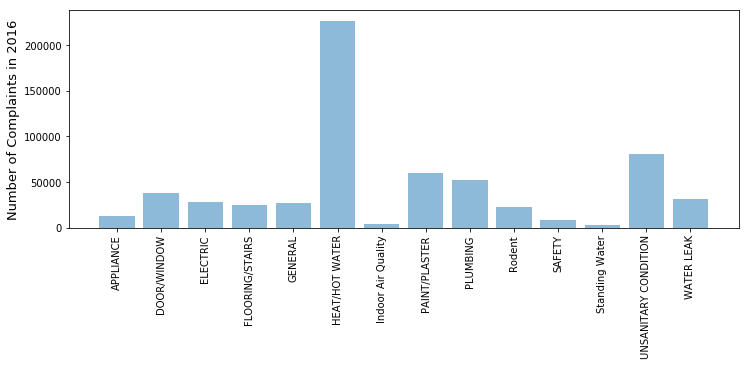

In [121]:
def plot_complaints_per_type(df, column):
    complaint1 = df.groupby(column)
    complaint = pd.DataFrame(complaint1[column].apply(np.size))
    complaint.rename(columns = {column:'Number_of_Calls'}, inplace = True)
    # next line eliminates complaint types with very few complaints
    complaint = complaint[complaint['Number_of_Calls'] > (np.max(complaint['Number_of_Calls'])/100)]
    complaint[column] = complaint.index
    
    objects = complaint[column]
    y_pos = np.arange(len(objects))
    number = complaint['Number_of_Calls']

    plt.figure(figsize=(12,4))
    plt.bar(y_pos, number, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation='vertical')
    plt.ylabel('Number of Complaints in 2016', fontsize=13)
    #plt.title('Complaints Per Type', fontsize=18)
    
plot_complaints_per_type(data, 'Complaint Type')

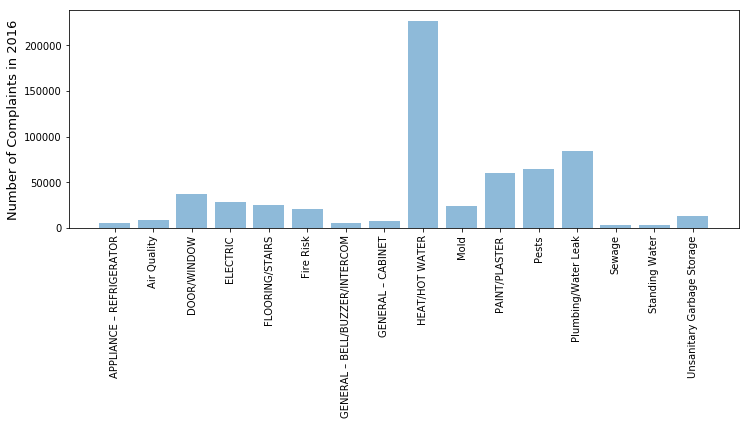

In [122]:
plot_complaints_per_type(data, 'New_Description')

Grouping by New_Description, counting the number in each group, and ranking the top ten.

In [123]:
def count_and_rank_by_column_value(df, column):
    description1 = df.groupby(column)
    description = pd.DataFrame(description1[column].apply(np.size))
    description.rename(columns = {column:'Number_of_Calls'}, inplace = True)
    description[column] = description.index
    description.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
    description.index = np.arange(1, len(description)+1)
    description.index.name = 'Rank'
    print(description.head(10))
    
count_and_rank_by_column_value(data, 'New_Description')

      Number_of_Calls             New_Description
Rank                                             
1              227075              HEAT/HOT WATER
2               84426         Plumbing/Water Leak
3               64956                       Pests
4               60260               PAINT/PLASTER
5               37494                 DOOR/WINDOW
6               27955                    ELECTRIC
7               24795             FLOORING/STAIRS
8               23688                        Mold
9               20876                   Fire Risk
10              13432  Unsanitary Garbage Storage


# 3. Counting total complaints per zip code

In [16]:
zips1 = data.groupby('Incident Zip')
zips = pd.DataFrame(zips1['Incident Zip'].apply(np.size))
zips.rename(columns = {'Incident Zip':'Number_of_Calls'}, inplace = True)
zips.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
zips.index.name = None
# zips['zip'] = zips.index
print('There are', len(zips), 'zip codes in the data.')
print('------------------------------')
print('These zip codes have only one call:', zips[zips['Number_of_Calls'] == 1.0])
print('------------------------------')
print(zips.head())
print('------------------------------')
zips['Number_of_Calls'].describe()

There are 187 zip codes in the data.
------------------------------
These zip codes have only one call:          Number_of_Calls
11202.0                1
11430.0                1
10162.0                1
10129.0                1
10000.0                1
------------------------------
         Number_of_Calls
11226.0            19980
10453.0            18925
10458.0            18303
10467.0            17230
10468.0            14927
------------------------------


count      187.000000
mean      3342.989305
std       4101.588937
min          1.000000
25%        564.000000
50%       1786.000000
75%       4280.000000
max      19980.000000
Name: Number_of_Calls, dtype: float64

This line saves the dataframe of complaints per zide code as a CSV. I will now visualize it using Carto.

In [137]:
csv_file_path = "complaints_per_zip.csv"

zips.to_csv(csv_file_path)

## RECOMMENDATION: The Tenant Support Unit should start with zip code 11226

# 4. Showing distribution of complaints per zip code

Text(0,0.5,'Number of Zip Codes')

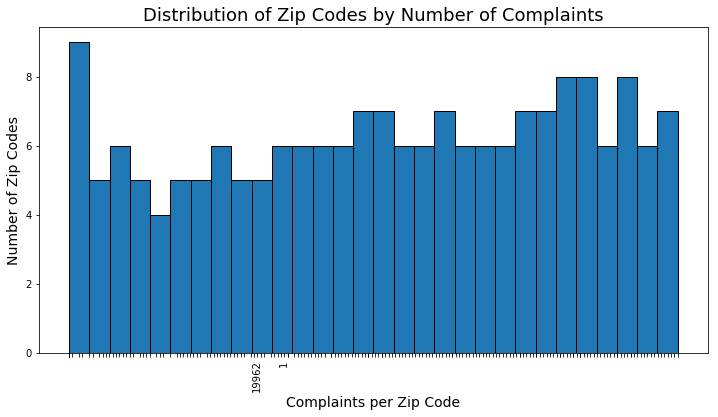

In [17]:
bins = 30

max_zips = 19962
min_zips = 1
range_zips = max_zips - min_zips
binSplit = range_zips/bins
labels = (min_zips, max_zips)

pl.figure(figsize=(12, 6))
pl.hist(zips, bins=bins, edgecolor='black', linewidth=1)
pl.xticks(zips['Number_of_Calls'], labels, rotation = 'vertical')
pl.title('Distribution of Zip Codes by Number of Complaints', fontsize = 18)
pl.xlabel('Complaints per Zip Code', fontsize = 14)
pl.ylabel('Number of Zip Codes', fontsize = 14)

In [18]:
# bins = 30
# # max_zips = np.max(data)
# # min_zips = np.min(data)
# # range_zips = max_zips - min_zips
# # binSplit = zips_range/bin_number

# # bins = np.arange(min_zips, max_zips, binSplit)
# ax = data.groupby(pd.cut(data['Incident Zip'], bins)).plot(kind='bar', legend=False)
# ax.set_title("Citi Bike Rider Age")

In [19]:
# x = [0,1,2]
# y = [90,40,65]
# labels = ['high', 'low', 37337]
# plt.plot(x,y, 'r')
# plt.xticks(x, labels, rotation='vertical')
# plt.show()

# 5. More detail on zip code 11226

In [124]:
target = data[data['Incident Zip'] == 11226.0]

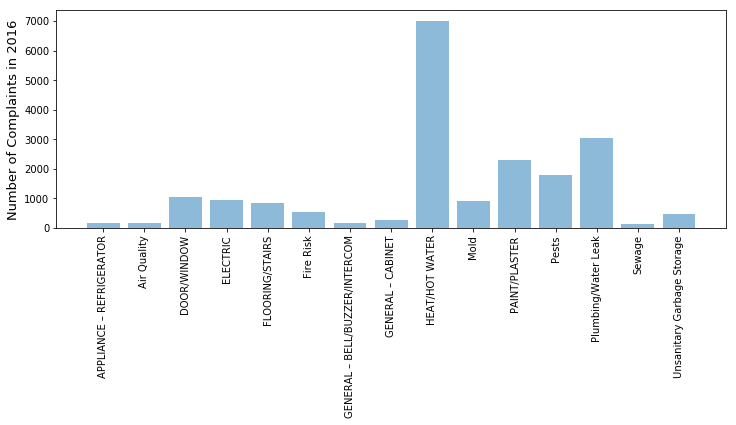

In [127]:
plot_complaints_per_type(target, 'New_Description')

In [126]:
count_and_rank_by_column_value(target, 'New_Description')

      Number_of_Calls             New_Description
Rank                                             
1                7015              HEAT/HOT WATER
2                3051         Plumbing/Water Leak
3                2312               PAINT/PLASTER
4                1774                       Pests
5                1038                 DOOR/WINDOW
6                 936                    ELECTRIC
7                 922                        Mold
8                 839             FLOORING/STAIRS
9                 527                   Fire Risk
10                469  Unsanitary Garbage Storage


## CITY COUNCILOR: these are the top ten tenant-related complaints in the most complained-about zip code in your district

# 5. Counting which properties have the most complaints.

In [129]:
props1 = data.groupby('Incident Address')
props = pd.DataFrame(props1['Incident Address'].apply(np.size))
props.rename(columns = {'Incident Address':'Number_of_Calls'}, inplace = True)
props.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
props.index.name = None

In [130]:
props.head()

,Number_of_Calls
1025 BOYNTON AVENUE,2644
89-21 ELMHURST AVENUE,1930
34 ARDEN STREET,1248
2181 BARNES AVENUE,1219
3451 GILES PLACE,1026


In [131]:
target_props1 = target.groupby('Incident Address')
target_props = pd.DataFrame(target_props1['Incident Address'].apply(np.size))
target_props.rename(columns = {'Incident Address':'Number_of_Calls'}, inplace = True)
target_props.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
target_props.index.name = None

In [143]:
print(len(target_props))
target_props.head(100)

1167


,Number_of_Calls
223 LINDEN BOULEVARD,674
120 EAST 19 STREET,246
2501 NEWKIRK AVENUE,215
250 EAST 29 STREET,214
667 OCEAN AVENUE,213
165 EAST 19 STREET,206
155 LINDEN BOULEVARD,200
21 ST PAULS COURT,193
2010 NEWKIRK AVENUE,187
60 CLARKSON AVENUE,186
